In [6]:
import pandas as pd

RESULT_DIR = "/mnt/d/Indago"
ALGOS = ["poison", "haircut", "seniority"]
VARIANTS = ["combined", "tornado", "known_addresses"]

In [7]:
known_addresses = pd.read_csv(f'{RESULT_DIR}/known-addresses.csv')

flagged: pd.Series = known_addresses[known_addresses.legitimacy == 0]
print(f'found {len(flagged)} addresses flagged as illegitimate.')
pre_flagged = len(flagged)

found 5204 addresses flagged as illegitimate.


In [21]:
def get_file_paths(algo, variant) -> tuple[str, str]:
    result_file = f'{RESULT_DIR}/{algo}/{algo}-addresses-{variant}.{"txt" if algo == "poison" else "csv"}'
    rundata_file = f'{RESULT_DIR}/{algo}/{algo}-rundata-{variant}.csv'
    return result_file, rundata_file

def get_rundata(algo, variant) -> pd.DataFrame:
    _, rundata_file = get_file_paths(algo, variant)
    df = pd.read_csv(rundata_file)
    df['algorithm'] = algo
    df['variant'] = variant
    df['title'] = f'{algo.capitalize()} ({variant.replace("_", " ").capitalize() if variant != "known_addresses" else "Flagged"})'
    return df

In [35]:
rundata = pd.concat([get_rundata(algo, variant) for algo in ALGOS for variant in VARIANTS if variant != "combined"]).reset_index(drop=True)
rundata = rundata[rundata.current_block != 0]
rundata.tail()

,rows_processed,n_blacklisted,processed_after_mins,current_block,ram_usage_gb,algorithm,variant,title,n_blacklisted_0_01,n_blacklisted_0_1,n_blacklisted_1,n_blacklisted_10,n_blacklisted_100
1050,1710000000,29438749,80.42,19106911,28.76,seniority,known_addresses,Seniority (Flagged),25029382.0,3753923.0,518660.0,112422.0,15500.0
1051,1720000000,29462435,80.92,19171519,28.80,seniority,known_addresses,Seniority (Flagged),25063542.0,3748364.0,514190.0,112029.0,15447.0
1052,1730000000,29497702,81.42,19239834,28.85,seniority,known_addresses,Seniority (Flagged),25099649.0,3749587.0,512801.0,111431.0,15373.0
1053,1740000000,29531481,81.90,19305601,28.90,seniority,known_addresses,Seniority (Flagged),25133185.0,3752062.0,511227.0,110841.0,15305.0
1054,1750000000,29585309,82.38,19367750,28.95,seniority,known_addresses,Seniority (Flagged),25175909.0,3765386.0,509889.0,110058.0,15209.0


[Text(0.5, 1.0, 'Addresses blacklisted over time'),
 Text(0.5, 0, 'Block number'),
 Text(0, 0.5, '# of addresses blacklisted')]

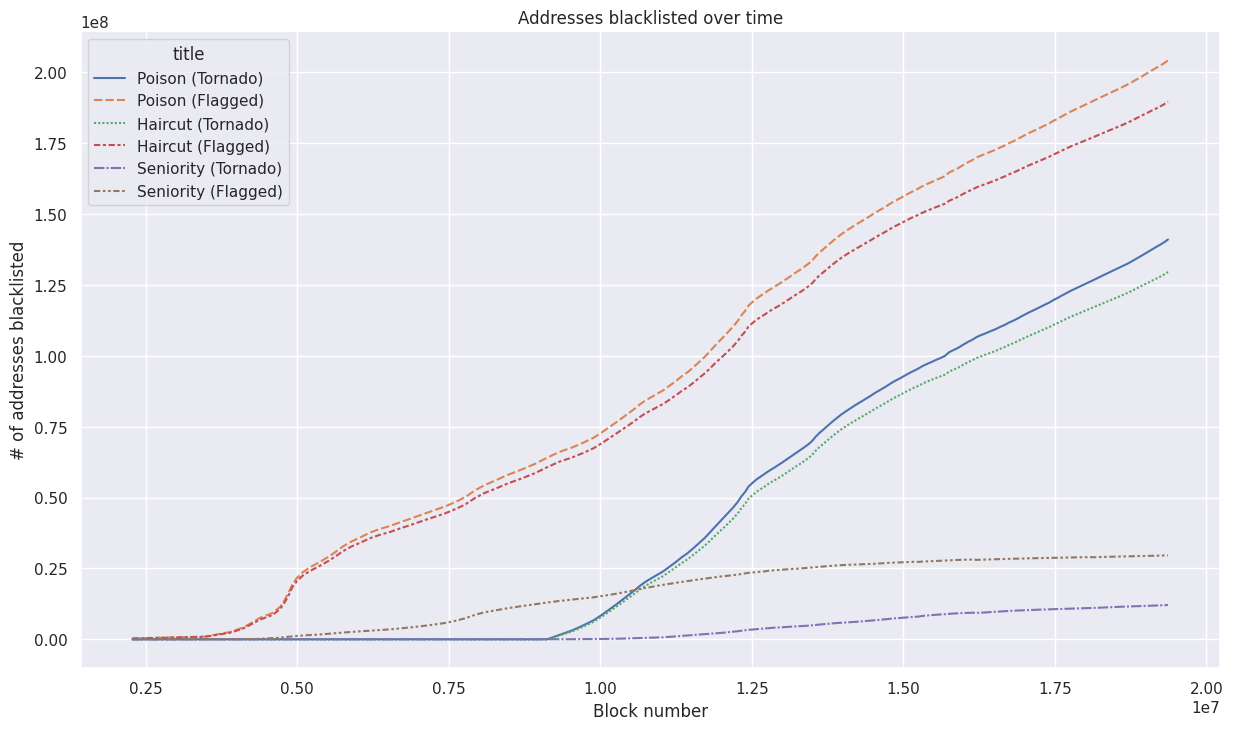

In [47]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib


# Create a visualization
sns.set_style("whitegrid")
sns.set_theme(rc={'figure.figsize': (14.7, 8.27)})
sns.lineplot(x='current_block', y='n_blacklisted', hue='title', style='title',
             data=rundata).set(title='Addresses blacklisted over time', xlabel='Block number', ylabel='# of addresses blacklisted')

[Text(0.5, 1.0, 'RAM usage over time'),
 Text(0.5, 0, 'Block number'),
 Text(0, 0.5, 'RAM used (GB)')]

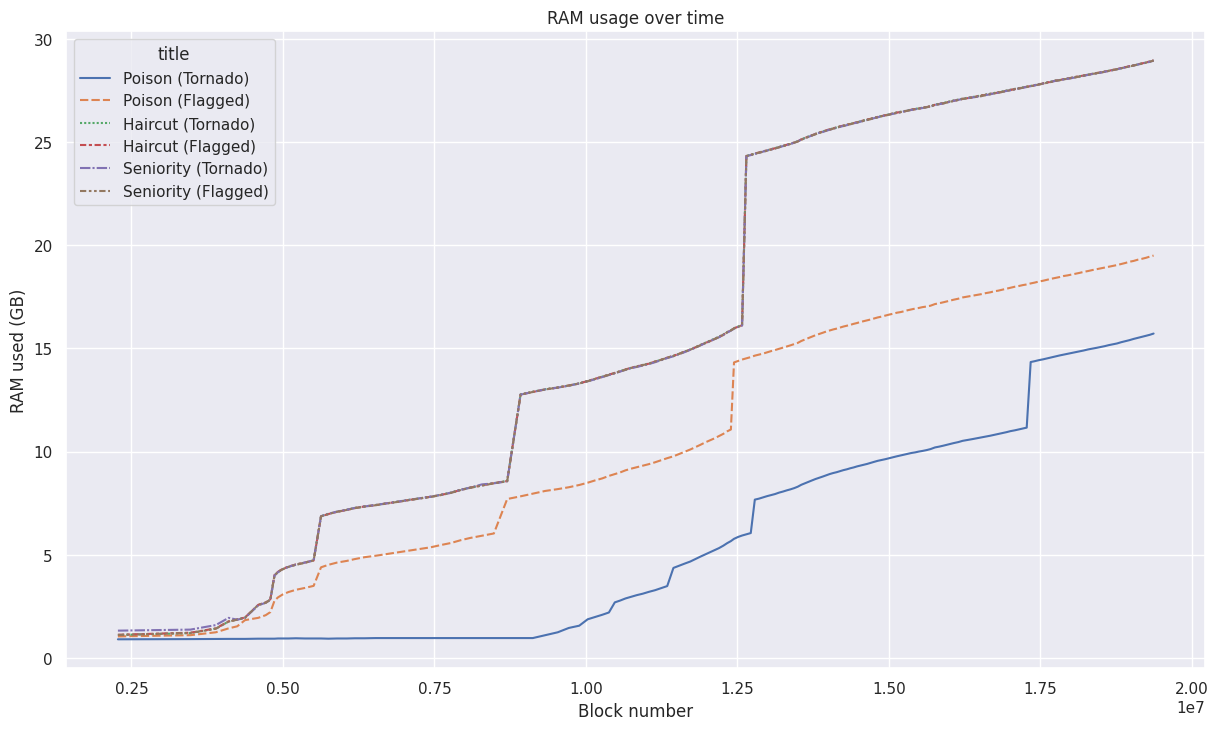

In [45]:
sns.lineplot(x='current_block', y='ram_usage_gb', hue='title', style='title',
             data=rundata).set(title='RAM usage over time', xlabel='Block number', ylabel='RAM used (GB)')

[Text(0.5, 1.0, 'Time to reach block'),
 Text(0.5, 0, 'Block number'),
 Text(0, 0.5, 'Processed after (minutes)')]

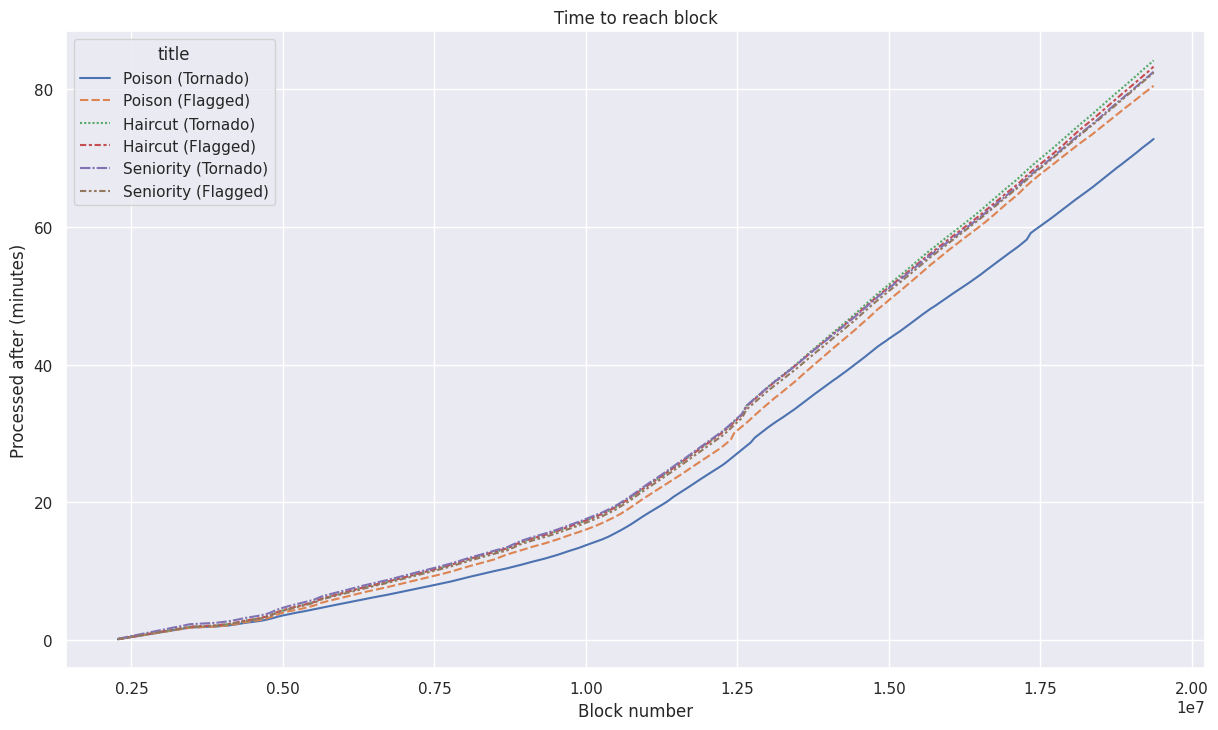

In [46]:
sns.lineplot(x='current_block', y='processed_after_mins', hue='title', style='title', data=rundata).set(title='Time to reach block', xlabel='Block number', ylabel='Processed after (minutes)')

In [49]:
threshold_columns = [f'n_blacklisted_{threshold}' for threshold in [0.01, 0.1, 1, 10, 100]]
thresholds = [0.01, 0.1, 1, 10, 100]

haircut_tornado = rundata[rundata.algorithm == 'haircut'][rundata.variant == 'tornado']
haircut_tornado.head()

/tmp/ipykernel_23539/2885120410.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  haircut_tornado = rundata[rundata.algorithm == 'haircut'][rundata.variant == 'tornado']


,rows_processed,n_blacklisted,processed_after_mins,current_block,ram_usage_gb,algorithm,variant,title,n_blacklisted_0_01,n_blacklisted_0_1,n_blacklisted_1,n_blacklisted_10,n_blacklisted_100
352,10000000,19,0.17,2276204,1.11,haircut,tornado,Haircut (Tornado),0.0,0.0,0.0,0.0,0.0
353,20000000,19,1.95,3472626,1.20,haircut,tornado,Haircut (Tornado),0.0,0.0,0.0,0.0,0.0
354,30000000,19,2.13,3892186,1.42,haircut,tornado,Haircut (Tornado),0.0,0.0,0.0,0.0,0.0
355,40000000,19,2.35,4102795,1.76,haircut,tornado,Haircut (Tornado),0.0,0.0,0.0,0.0,0.0
356,50000000,19,2.57,4244984,1.86,haircut,tornado,Haircut (Tornado),0.0,0.0,0.0,0.0,0.0


# Haircut stuff

In [ ]:
import pandas as pd
from tqdm import tqdm

RESULT_DIR = '/media/ponbac/BigHDD/ethereum'
HAIRCUT_DIR = f'{RESULT_DIR}/blacklist/haircut'
FLAGGED_RESULT = f'{HAIRCUT_DIR}/haircut-flagged-result.csv'
TORNADO_RESULT = f'{HAIRCUT_DIR}/haircut-tornado-result.csv'

CHUNK_SIZE = 100000
#flagged_iter = pd.read_csv(FLAGGED_RESULT, chunksize=CHUNK_SIZE)
#tornado_iter = pd.read_csv(TORNADO_RESULT, chunksize=CHUNK_SIZE)

def calc_addresses_over_threshold(iter, threshold: float, chunk_size=100000, n_iter=984, isWei=False):
    THRESHOLD_ETH = threshold
    addresses_over_threshold = 0
    pbar = tqdm(total=n_iter)
    for chunk in iter:
        if isWei:
            chunk = chunk[chunk['taint'] / 10**18 > THRESHOLD_ETH]
        else:
            chunk = chunk[chunk['taint'] > THRESHOLD_ETH]
        addresses_over_threshold += len(chunk)
        pbar.update(1)
    pbar.close()
    print(f'Addresses over {THRESHOLD_ETH} ETH: {addresses_over_threshold}')

print('Flagged')
calc_addresses_over_threshold(pd.read_csv(FLAGGED_RESULT, chunksize=CHUNK_SIZE), 0.001, n_iter=1516)
calc_addresses_over_threshold(pd.read_csv(FLAGGED_RESULT, chunksize=CHUNK_SIZE), 0.01, n_iter=1516)
calc_addresses_over_threshold(pd.read_csv(FLAGGED_RESULT, chunksize=CHUNK_SIZE), 0.1, n_iter=1516)
calc_addresses_over_threshold(pd.read_csv(FLAGGED_RESULT, chunksize=CHUNK_SIZE), 1, n_iter=1516)

print('\nTornado')
calc_addresses_over_threshold(pd.read_csv(TORNADO_RESULT, chunksize=CHUNK_SIZE), 0.001, n_iter=984)
calc_addresses_over_threshold(pd.read_csv(TORNADO_RESULT, chunksize=CHUNK_SIZE), 0.01, n_iter=984)
calc_addresses_over_threshold(pd.read_csv(TORNADO_RESULT, chunksize=CHUNK_SIZE), 0.1, n_iter=984)
calc_addresses_over_threshold(pd.read_csv(TORNADO_RESULT, chunksize=CHUNK_SIZE), 1, n_iter=984)

# Seniority stuff

In [ ]:
import pandas as pd
from tqdm import tqdm

RESULT_DIR = '/media/ponbac/BigHDD/ethereum'
SENIORITY_DIR = f'{RESULT_DIR}/blacklist/seniority'
FLAGGED_RESULT = f'{SENIORITY_DIR}/seniority-flagged-result.csv'
TORNADO_RESULT = f'{SENIORITY_DIR}/seniority-tornado-result.csv'

CHUNK_SIZE = 100_000

print('Flagged')
calc_addresses_over_threshold(pd.read_csv(FLAGGED_RESULT, chunksize=CHUNK_SIZE), 0.001, n_iter=573, isWei=True)
calc_addresses_over_threshold(pd.read_csv(FLAGGED_RESULT, chunksize=CHUNK_SIZE), 0.01, n_iter=573, isWei=True)
calc_addresses_over_threshold(pd.read_csv(FLAGGED_RESULT, chunksize=CHUNK_SIZE), 0.1, n_iter=573, isWei=True)
calc_addresses_over_threshold(pd.read_csv(FLAGGED_RESULT, chunksize=CHUNK_SIZE), 1, n_iter=573, isWei=True)

print('\nTornado')
calc_addresses_over_threshold(pd.read_csv(TORNADO_RESULT, chunksize=CHUNK_SIZE), 0.001, n_iter=362, isWei=True)
calc_addresses_over_threshold(pd.read_csv(TORNADO_RESULT, chunksize=CHUNK_SIZE), 0.01, n_iter=362, isWei=True)
calc_addresses_over_threshold(pd.read_csv(TORNADO_RESULT, chunksize=CHUNK_SIZE), 0.1, n_iter=362, isWei=True)
calc_addresses_over_threshold(pd.read_csv(TORNADO_RESULT, chunksize=CHUNK_SIZE), 1, n_iter=362, isWei=True)